In [1]:
# Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import customer methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

%load_ext autoreload
%autoreload 2

In [3]:
# Read in data, check formatting compatibility
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
labels = pd.read_pickle(pickle_path / "labels.pkl")
X = pd.read_pickle(pickle_path / "X_all.pkl")
y = pd.read_pickle(pickle_path / "y_all.pkl")

if X.shape[0] != y.shape[0]: 
    # TODO: Raise Error
    print("ERROR. Dataframe shapes don't match.")
    print("X Rows: {}".format(X.shape))
    print("y Rows: {}".format(y.shape))

In [4]:
# Remove houses without EVs
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")
print("{} Houses without EVs".format(len(houses_woEV)))

y = y.drop(houses_woEV, errors='ignore')
X = X.drop(houses_woEV, errors='ignore')

print("Features:")
for feature in X.columns.tolist(): 
    print("\t" + feature)

1105 Houses without EVs
Features:
	value
	diff
	h8_avg
	h24_avg
	h24_min
	h24_max
	h72_avg
	diff_2
	diff_3
	diff_5


In [59]:
# Proceeding with all features
# Scale X-data between -1 and 1
scaler = StandardScaler().fit(X)                                    
X_scaled = pd.DataFrame(scaler.transform(X), 
                        index=X.index, 
                        columns=X.columns)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

# Train logistic regression model
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)
score = logreg.score(X_test, y_test)

print("Test Score: {:.3f}".format(score))

Test Score: 0.946


In [9]:
# Evaluate Model
# Join Confusion matrix with other data

results = X_test.join(y_test.rename('label_true'))
results.head()

# Predict bool classification
y_pred = logreg.predict(X_test)
y_pred = pd.DataFrame(y_pred, 
                      index=X_test.index, 
                      columns=['label_pred'])

# Probability for each testing classification
probs = logreg.predict_proba(X_test)[:,1]
probs = pd.DataFrame(probs, 
                     index=X_test.index, 
                     columns=['label_prob'])


results = results.join(y_pred)
results = results.join(probs)
results.head()

,,value,diff,h8_avg,h24_avg,h24_min,h24_max,h72_avg,diff_2,diff_3,diff_5,label_true,label_pred,label_prob
House ID,,,,,,,,,,,,,,
11650698,Interval_363,0.272896,0.810086,-0.438764,-0.032059,-0.309952,0.653146,-0.077920,-0.072839,0.009842,-0.003572,0.0,0.0,0.025503
11639403,Interval_2440,-0.146830,-0.320916,1.268724,0.658936,0.076974,0.162190,0.925085,-0.189953,-0.005106,-0.003658,0.0,0.0,0.003878
11640980,Interval_2854,-0.778823,-0.213907,-0.858461,-0.709185,-0.612318,-0.975479,-0.741140,-0.202079,-0.004489,-0.003657,0.0,0.0,0.019846
11637471,Interval_944,-0.118795,0.001757,1.271712,-0.033737,-0.522634,0.010646,-0.457655,-0.211778,-0.004229,-0.003657,0.0,0.0,0.020542
11642554,Interval_867,-0.319847,-0.829620,-0.101699,-0.394378,-0.763501,-0.985439,-0.074867,-0.065979,-0.019356,-0.003753,0.0,0.0,0.027996


In [72]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
y_true = results['label_true']
y_scores = results['label_prob']

# ROC
auc = roc_auc_score(y_true, y_scores)
print("AUC Score: {:.3f}".format(auc))
fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)

# Precision-Recall (PR) Curve
ap = average_precision_score(y_true, y_scores)  
print("Average Precision Score: {:.3f}".format(ap))
p, r, thresholds_pr = precision_recall_curve(y_true, y_scores)



AUC Score: 0.925
Average Precision Score: 0.624


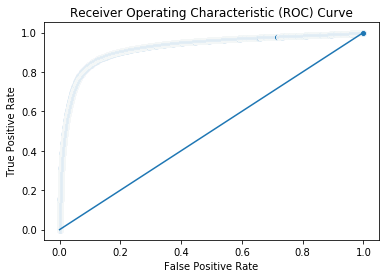

In [73]:
sns.scatterplot(x=fpr, y=tpr, markers='.')
sns.lineplot(x=[0,1], y=[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

Text(0.5, 1.0, 'PR Curve')

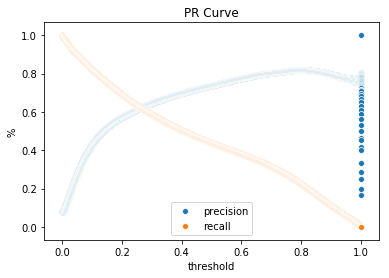

In [77]:
t = np.append(thresholds_pr, 1) 
if p.shape[0] != r.shape[0] != thresholds.shape[0]: 
    print("Error. Incorrect Shapes")
    print(p.shape[0], r.shape[0], t.shape[0])

sns.scatterplot(t, p) 
sns.scatterplot(t, r)
# sns.scatterplot(thresholds, queue_rate) 
leg = plt.legend(('precision', 'recall'), frameon=True) 
plt.xlabel('threshold') 
plt.ylabel('%')
plt.title('PR Curve')